In [1]:
# Cell 0: Import libraries
import warnings, re
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", context="notebook")

RANDOM_STATE = 42


In [2]:
# Cell 1: Load dataset
FILE = "Bean Multiclass classification model.xlsx"  # or .xlsx

if FILE.lower().endswith(".csv"):
    df = pd.read_csv(FILE)
else:
    df = pd.read_excel(FILE)

df.head()


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [3]:
# Cell 2: Basic info
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())
print("\nDuplicates:", df.duplicated().sum())


Shape: (13611, 17)

Dtypes:
 Area                 int64
Perimeter          float64
MajorAxisLength    float64
MinorAxisLength    float64
AspectRation       float64
Eccentricity       float64
ConvexArea           int64
EquivDiameter      float64
Extent             float64
Solidity           float64
roundness          float64
Compactness        float64
ShapeFactor1       float64
ShapeFactor2       float64
ShapeFactor3       float64
ShapeFactor4       float64
Class               object
dtype: object

Missing values:
 Area               0
Perimeter          0
MajorAxisLength    0
MinorAxisLength    0
AspectRation       0
Eccentricity       0
ConvexArea         0
EquivDiameter      0
Extent             0
Solidity           0
roundness          0
Compactness        0
ShapeFactor1       0
ShapeFactor2       0
ShapeFactor3       0
ShapeFactor4       0
Class              0
dtype: int64

Duplicates: 68


In [3]:
# Cell 3: Remove duplicates
print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Shape after duplicates removed:", df.shape)


# Check for zero-variance columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
zero_var = [c for c in num_cols if df[c].nunique() <= 1]
print("Zero variance features:", zero_var)


Duplicates before: 68
Shape after duplicates removed: (13543, 17)
Zero variance features: []


In [4]:
# Cell 4: Rename columns (typo fix + snake_case)
def to_snake(name):
    name = re.sub(r"(?<!^)([A-Z])", r"_\1", name).replace(" ", "_").lower()
    return name

df.rename(columns={"AspectRation": "AspectRatio"}, inplace=True)

new_cols = {c: to_snake(c) for c in df.columns}
df.rename(columns=new_cols, inplace=True)

df.head()


,area,perimeter,major_axis_length,minor_axis_length,aspect_ratio,eccentricity,convex_area,equiv_diameter,extent,solidity,roundness,compactness,shape_factor1,shape_factor2,shape_factor3,shape_factor4,class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


          count   ratio
class                  
DERMASON   3546  0.2618
SIRA       2636  0.1946
SEKER      2027  0.1497
HOROZ      1860  0.1373
CALI       1630  0.1204
BARBUNYA   1322  0.0976
BOMBAY      522  0.0385


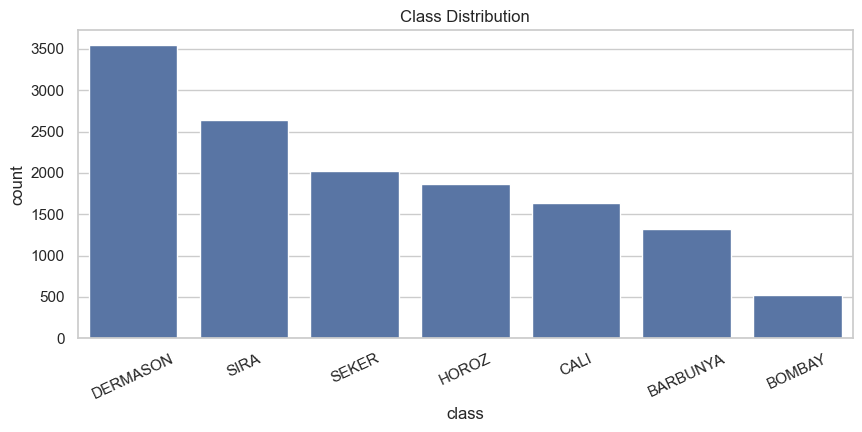

In [5]:
# Cell 5: Class counts
target_col = "class"
class_counts = df[target_col].value_counts()
class_ratio = class_counts / len(df)

print(pd.DataFrame({"count": class_counts, "ratio": class_ratio.round(4)}))

plt.figure(figsize=(10,4))
sns.countplot(data=df, x=target_col, order=class_counts.index)
plt.title("Class Distribution")
plt.xticks(rotation=25)
plt.show()


In [6]:
# After renaming columns to snake_case, redefine numeric columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()

# Now this will work:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
area,13543.0,53048.460385,29392.438324,20420.000000,36282.500000,44580.000000,61382.000000,254616.000000
perimeter,13543.0,854.993406,214.722684,524.736000,703.230000,793.896000,977.146500,1985.370000
major_axis_length,13543.0,319.895602,85.809260,183.601165,253.086806,296.404589,376.312489,738.860153
minor_axis_length,13543.0,202.365321,45.051632,122.512653,175.886357,192.491117,217.245403,460.198497
aspect_ratio,13543.0,1.581075,0.245245,1.024868,1.430662,1.549860,1.703916,2.430306
eccentricity,13543.0,0.750315,0.091858,0.218951,0.715144,0.763997,0.809671,0.911423
convex_area,13543.0,53767.986709,29844.248525,20684.000000,36673.000000,45122.000000,62360.000000,263261.000000
equiv_diameter,13543.0,253.034094,59.307709,161.243764,214.933277,238.245711,279.560351,569.374358
extent,13543.0,0.749829,0.048939,0.555315,0.718735,0.759903,0.786849,0.866195
solidity,13543.0,0.987152,0.004650,0.919246,0.985678,0.988288,0.990019,0.994677


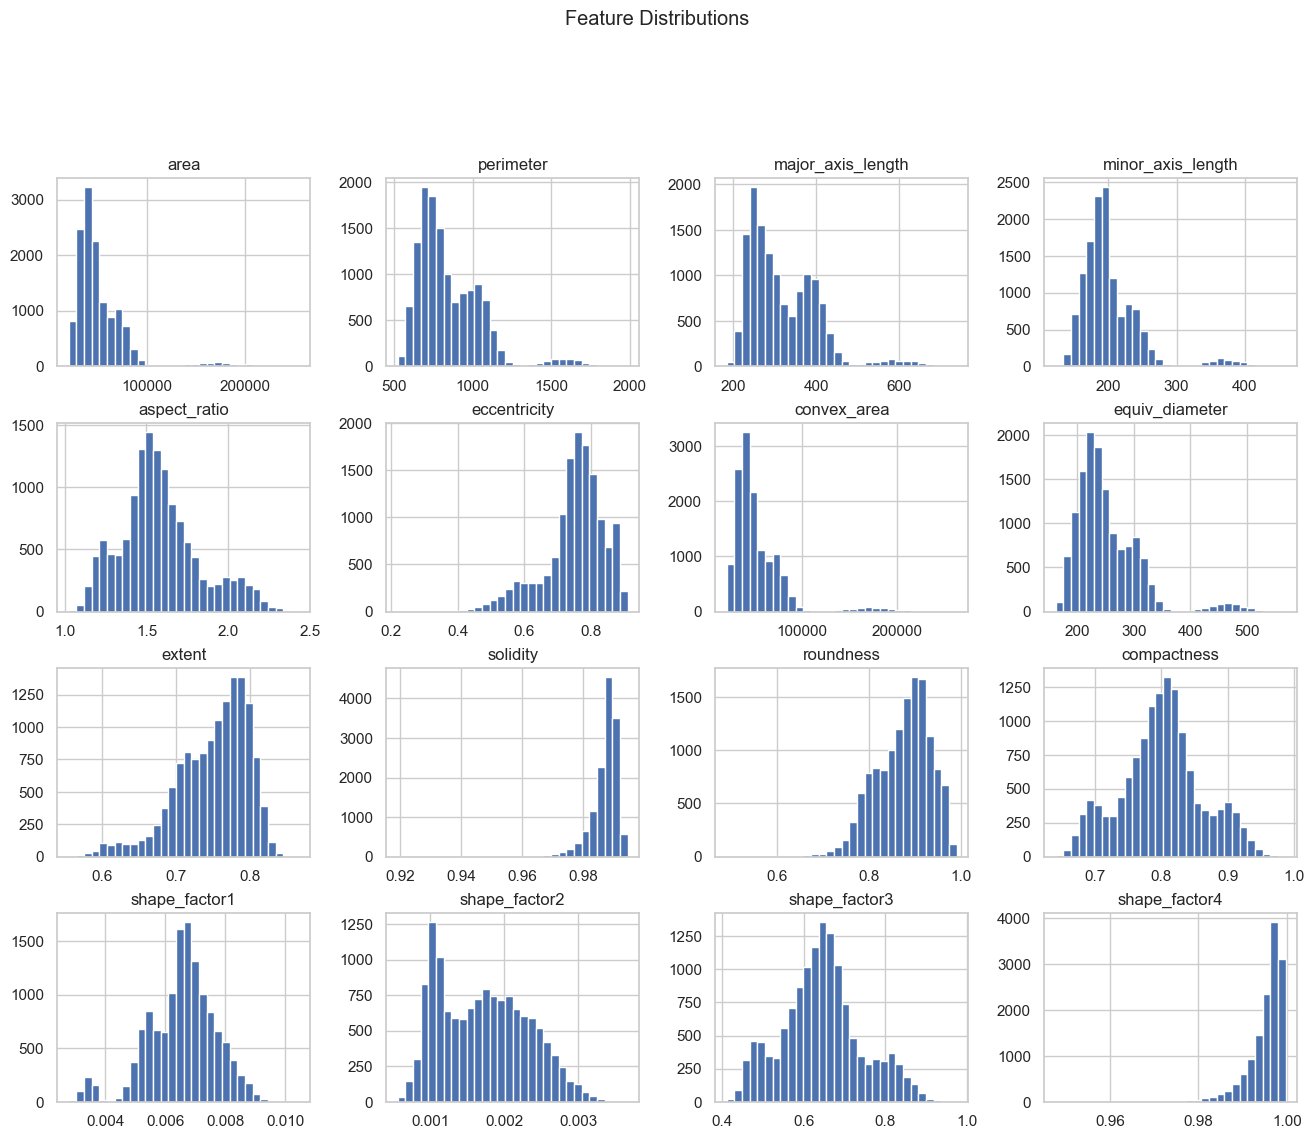

In [15]:
# Cell 7: Histograms
df[num_cols].hist(bins=30, figsize=(16,12))
plt.suptitle("Feature Distributions", y=1.02)
plt.show()


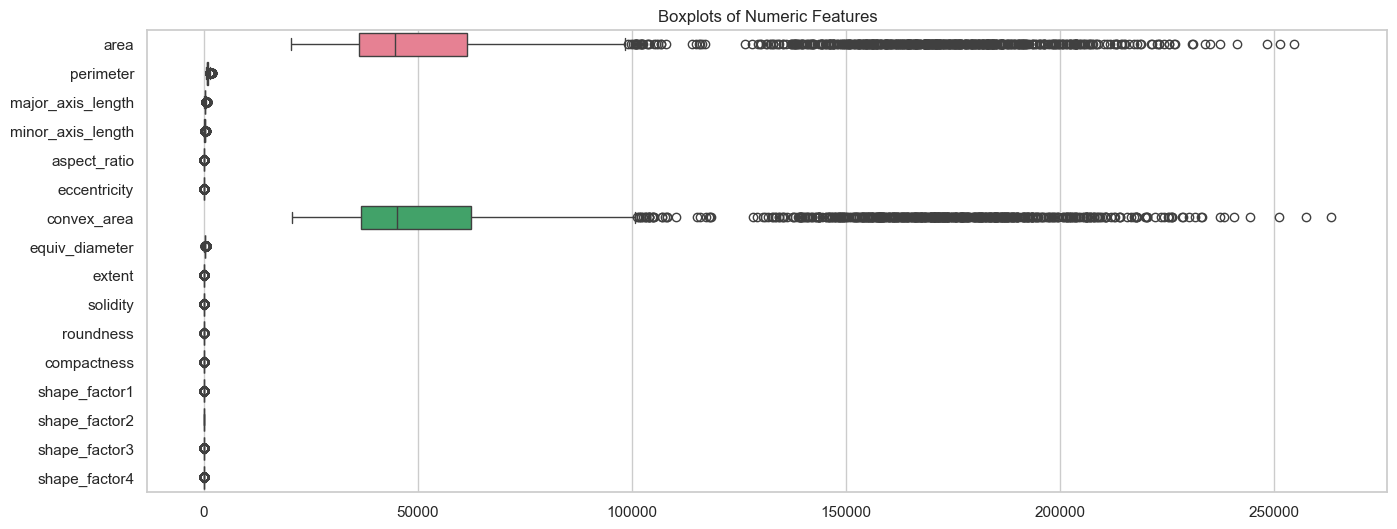

In [7]:
# Cell 8: Boxplots
plt.figure(figsize=(16,6))
sns.boxplot(data=df[num_cols], orient="h")
plt.title("Boxplots of Numeric Features")
plt.show()


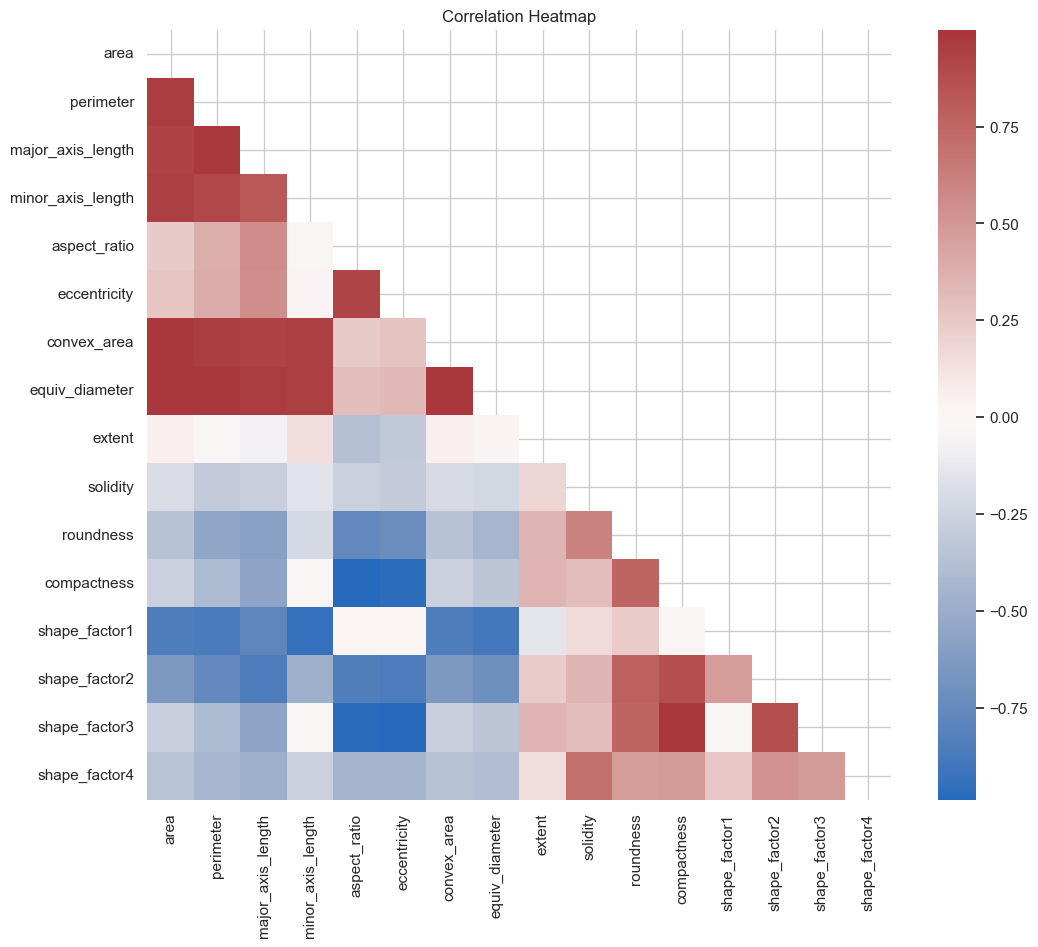

In [8]:
# Cell 9: Correlation matrix
corr = df[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, cmap="vlag", center=0)
plt.title("Correlation Heatmap")
plt.show()


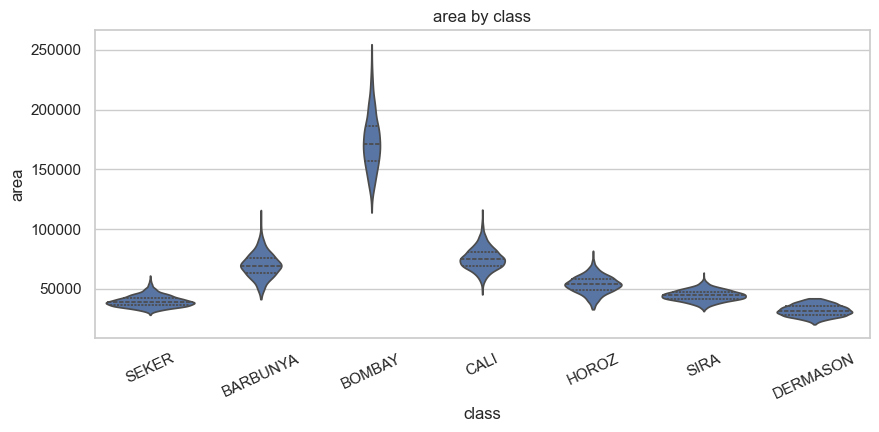

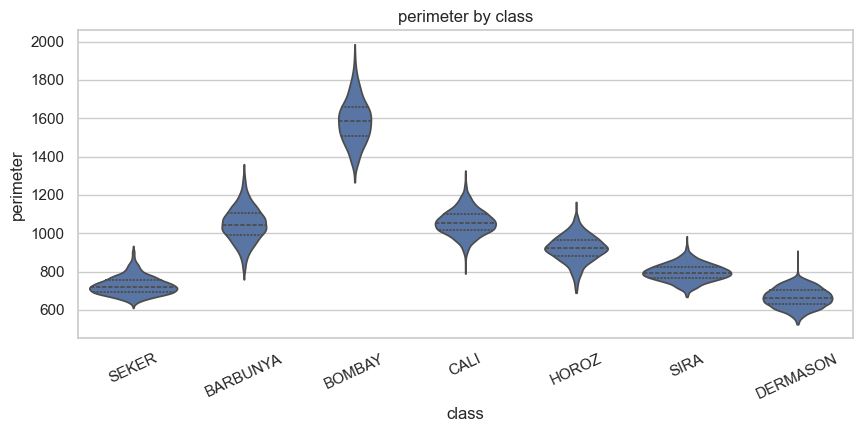

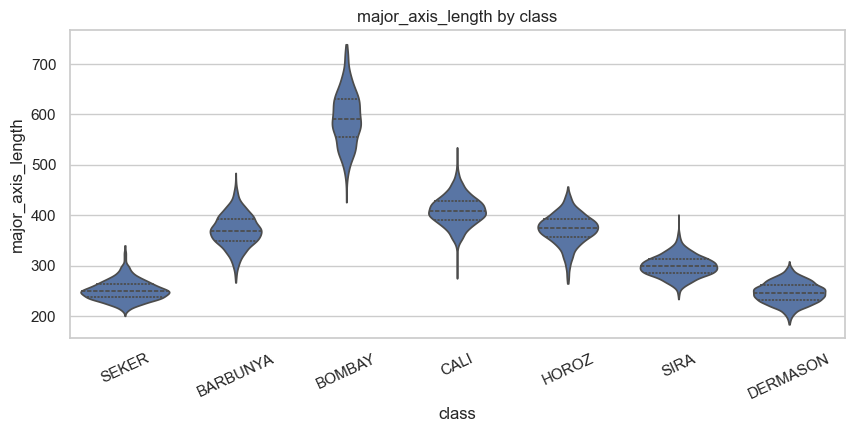

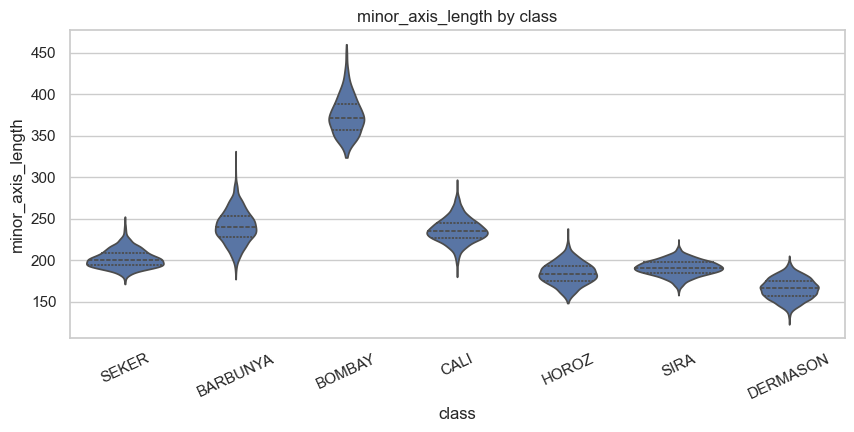

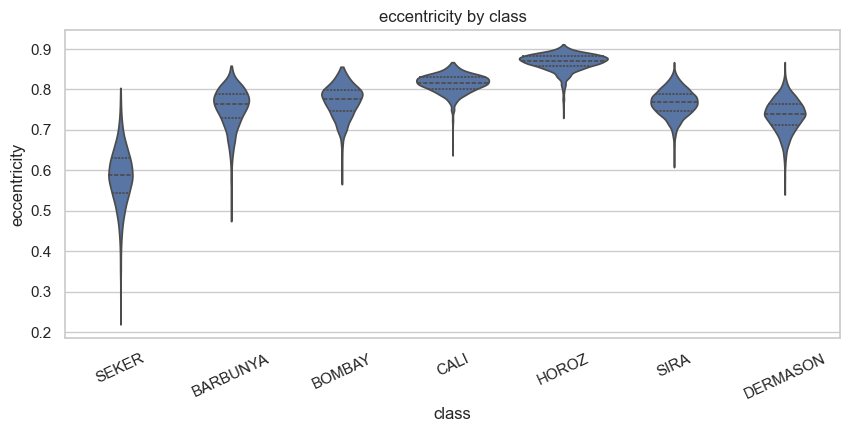

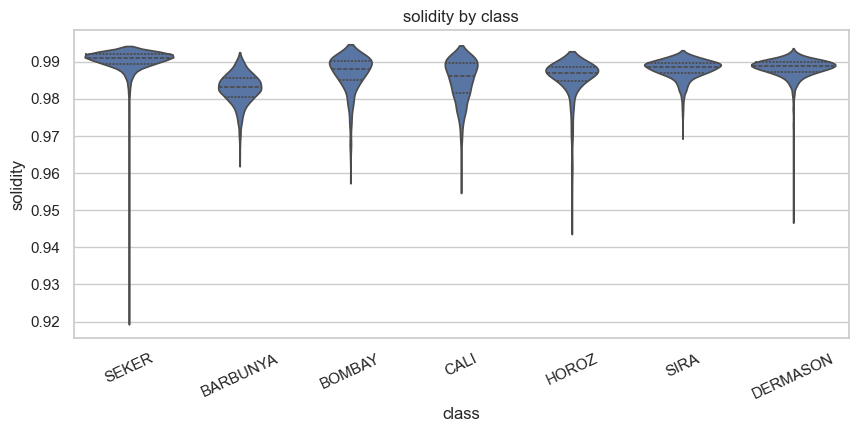

In [18]:
# Cell 10: Sample violin plots
features = ["area","perimeter","major_axis_length","minor_axis_length","eccentricity","solidity"]
for c in features:
    plt.figure(figsize=(10,4))
    sns.violinplot(data=df, x=target_col, y=c, inner="quartile", cut=0)
    plt.title(f"{c} by class")
    plt.xticks(rotation=25)
    plt.show()


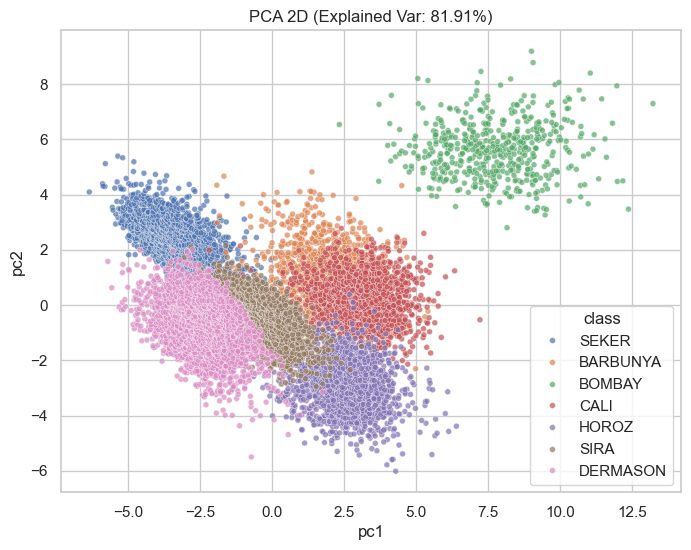

In [9]:
# Cell 11: PCA for visualization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df[num_cols]
y = df[target_col]

X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({"pc1": X_pca[:,0], "pc2": X_pca[:,1], "class": y})

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="pc1", y="pc2", hue="class", s=18, alpha=0.7)
plt.title(f"PCA 2D (Explained Var: {pca.explained_variance_ratio_.sum():.2%})")
plt.show()


In [10]:
# Cell 12: Save for modeling
df.to_csv("dry_bean_clean.csv", index=False)
print("Saved clean dataset → dry_bean_clean.csv")


Saved clean dataset → dry_bean_clean.csv


In [11]:
# Cell 0: Modeling libraries
!pip install xgboost

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [12]:
# Cell 1: Features and target
X = df.drop(columns=["class"])
y = df["class"]

# Encode target (class → numeric)
le = LabelEncoder()
y = le.fit_transform(y)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (10834, 16)  Test shape: (2709, 16)


In [13]:
# Cell 2: Apply SMOTE (only to train data)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", dict(pd.Series(y_train).value_counts()))
print("After SMOTE:", dict(pd.Series(y_train_res).value_counts()))


Before SMOTE: {3: 2837, 6: 2109, 5: 1621, 4: 1488, 2: 1304, 0: 1057, 1: 418}
After SMOTE: {2: 2837, 0: 2837, 4: 2837, 6: 2837, 3: 2837, 5: 2837, 1: 2837}


In [14]:
# Cell 3: Define classifiers
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}


In [15]:
# Cell 4: Train + evaluate
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    pipe = Pipeline([("scaler", StandardScaler()), ("clf", model)])
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")  # macro handles imbalance
    
    print(f"\n{name} Results:")
    print("Accuracy:", round(acc,4))
    print("Macro F1:", round(f1,4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    return {"Model": name, "Accuracy": acc, "Macro_F1": f1}



LogisticRegression Results:
Accuracy: 0.9155
Macro F1: 0.9281

Classification Report:
               precision    recall  f1-score   support

    BARBUNYA       0.92      0.90      0.91       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.91      0.94      0.93       326
    DERMASON       0.94      0.88      0.91       709
       HOROZ       0.97      0.94      0.96       372
       SEKER       0.92      0.95      0.93       406
        SIRA       0.84      0.90      0.86       527

    accuracy                           0.92      2709
   macro avg       0.93      0.93      0.93      2709
weighted avg       0.92      0.92      0.92      2709



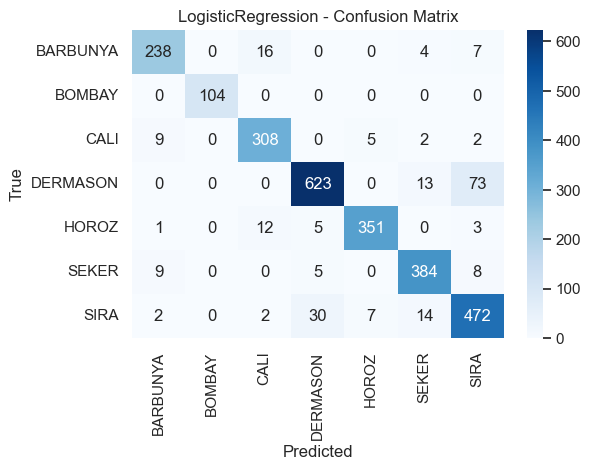


KNN Results:
Accuracy: 0.9118
Macro F1: 0.9251

Classification Report:
               precision    recall  f1-score   support

    BARBUNYA       0.91      0.91      0.91       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.91      0.94      0.92       326
    DERMASON       0.93      0.89      0.91       709
       HOROZ       0.96      0.94      0.95       372
       SEKER       0.93      0.93      0.93       406
        SIRA       0.83      0.88      0.85       527

    accuracy                           0.91      2709
   macro avg       0.92      0.93      0.93      2709
weighted avg       0.91      0.91      0.91      2709



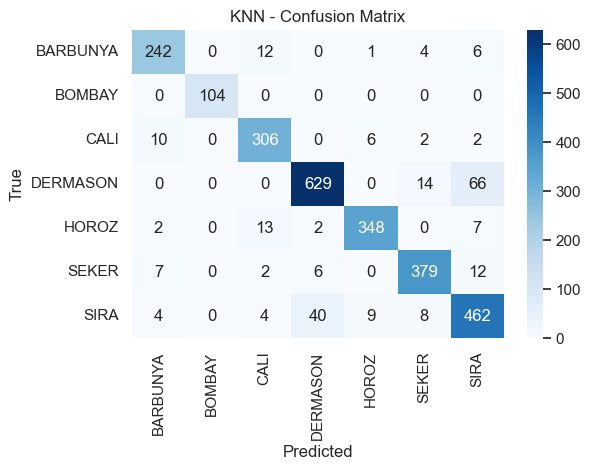


DecisionTree Results:
Accuracy: 0.8885
Macro F1: 0.9033

Classification Report:
               precision    recall  f1-score   support

    BARBUNYA       0.87      0.88      0.88       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.88      0.92      0.90       326
    DERMASON       0.90      0.88      0.89       709
       HOROZ       0.92      0.91      0.91       372
       SEKER       0.92      0.95      0.93       406
        SIRA       0.83      0.80      0.81       527

    accuracy                           0.89      2709
   macro avg       0.90      0.91      0.90      2709
weighted avg       0.89      0.89      0.89      2709



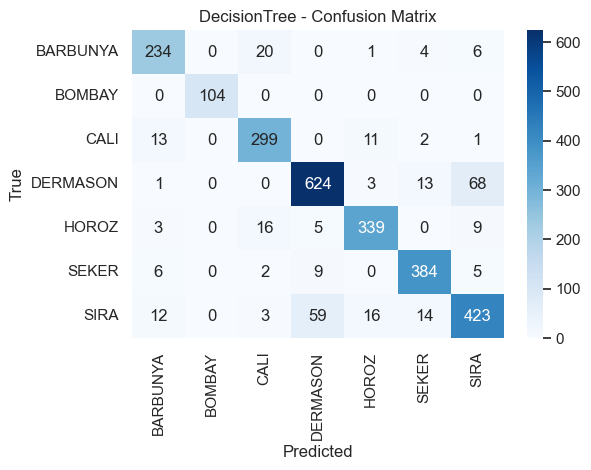


RandomForest Results:
Accuracy: 0.9162
Macro F1: 0.9285

Classification Report:
               precision    recall  f1-score   support

    BARBUNYA       0.92      0.90      0.91       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.92      0.94      0.93       326
    DERMASON       0.92      0.91      0.91       709
       HOROZ       0.96      0.94      0.95       372
       SEKER       0.93      0.95      0.94       406
        SIRA       0.85      0.86      0.86       527

    accuracy                           0.92      2709
   macro avg       0.93      0.93      0.93      2709
weighted avg       0.92      0.92      0.92      2709



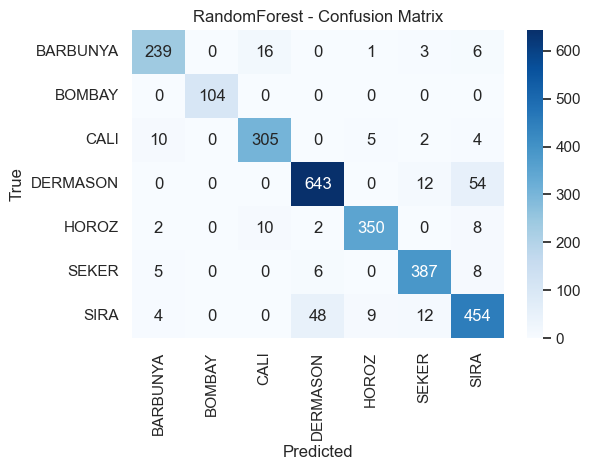


SVM Results:
Accuracy: 0.9221
Macro F1: 0.9334

Classification Report:
               precision    recall  f1-score   support

    BARBUNYA       0.93      0.91      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.92      0.94      0.93       326
    DERMASON       0.94      0.89      0.92       709
       HOROZ       0.97      0.95      0.96       372
       SEKER       0.92      0.95      0.94       406
        SIRA       0.86      0.90      0.88       527

    accuracy                           0.92      2709
   macro avg       0.93      0.93      0.93      2709
weighted avg       0.92      0.92      0.92      2709



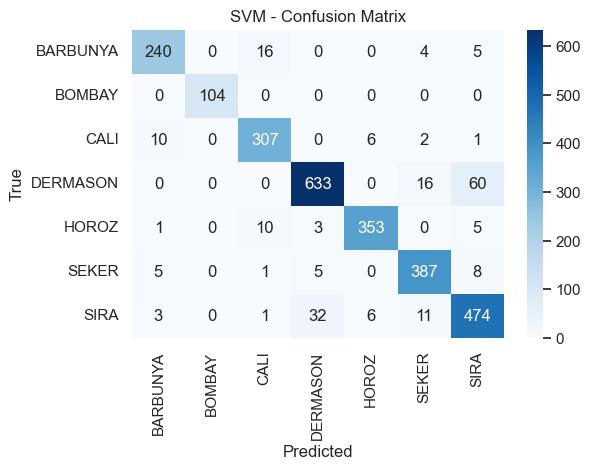


XGBoost Results:
Accuracy: 0.9188
Macro F1: 0.9303

Classification Report:
               precision    recall  f1-score   support

    BARBUNYA       0.91      0.90      0.91       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.93      0.93      0.93       326
    DERMASON       0.92      0.91      0.92       709
       HOROZ       0.96      0.96      0.96       372
       SEKER       0.92      0.94      0.93       406
        SIRA       0.86      0.87      0.87       527

    accuracy                           0.92      2709
   macro avg       0.93      0.93      0.93      2709
weighted avg       0.92      0.92      0.92      2709



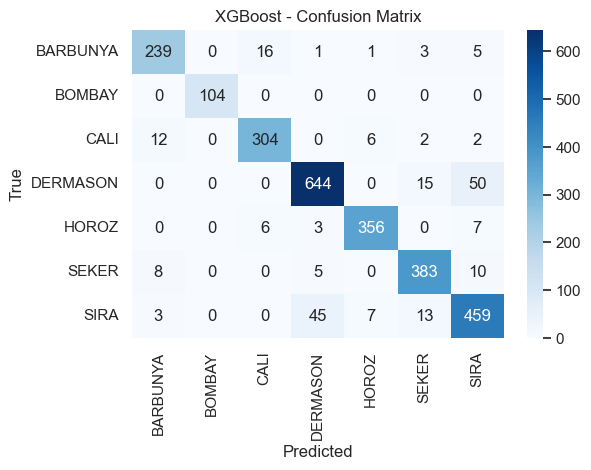

,Model,Accuracy,Macro_F1
4,SVM,0.922111,0.933393
5,XGBoost,0.918789,0.930348
3,RandomForest,0.916205,0.928499
0,LogisticRegression,0.915467,0.928145
1,KNN,0.911776,0.925130
2,DecisionTree,0.888520,0.903298


In [16]:
# Cell 5: Compare all models
results = []
for name, model in models.items():
    res = evaluate_model(name, model, X_train_res, y_train_res, X_test, y_test)
    results.append(res)

results_df = pd.DataFrame(results).sort_values(by="Macro_F1", ascending=False)
results_df


In [17]:
results_df

,Model,Accuracy,Macro_F1
4,SVM,0.922111,0.933393
5,XGBoost,0.918789,0.930348
3,RandomForest,0.916205,0.928499
0,LogisticRegression,0.915467,0.928145
1,KNN,0.911776,0.925130
2,DecisionTree,0.888520,0.903298


Done

---

### SVM is the top performer in both metrics.

### XGBoost is a strong alternative, especially if you want tree-based models.

In [18]:
import pickle

# Save trained model to a file
with open("bean_model.pkl", "wb") as f:
    pickle.dump(svm_model, f)


NameError: name 'svm_model' is not defined

In [19]:
import pickle

svm_model = models["SVM"]  # this is the trained SVM model

with open("bean_model.pkl", "wb") as f:
    pickle.dump(svm_model, f)

In [20]:
with open("bean_model.pkl", "rb") as f:
    loaded_svm = pickle.load(f)

loaded_svm.predict(X_test.iloc[:1])

array([4])